# Analyze false classifications

## View some false classifications

In [1]:
import pandas as pd

def load_df(model_type):
    path = f"../data/dfs/{model_type}/ReferenceErrorDetection_data_with_prompt_results.pkl"
    df = pd.read_pickle(path)
    return df

In [5]:
def remove_json_colons(json_text):
    if json_text and json_text.startswith("```json") and json_text.rstrip().endswith("```"):
        return json_text[7:-3]
    return json_text

In [6]:
import json

# Add extra columns for the model classification label and explanation by extracting the information from the JSON
# If the JSON is misformed due to leading ```json and trailing ``` then remove them
# Make sure that correct label and model label are both lower case and do not end with d (unsubstaniate instead of unsubstantiated)
def reshape_model_classification(df):
    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            try:
                row['Model Classification'] = remove_json_colons(row['Model Classification'])
                model_classification = json.loads(row['Model Classification'])
                label = model_classification['label'].lower()
                df.at[row.name, 'Model Classification Label'] = label if not label.endswith('d') else label[:-1]
                df.at[row.name, 'Model Classification Explanation'] = model_classification['explanation']
            except json.JSONDecodeError as e:
                print(f"Row {index} Model Classification could not be decoded: {e}")
                print(row['Model Classification'])
                df.at[row.name, 'Model Classification Label'] = None
                df.at[row.name, 'Model Classification Explanation'] = None
        else:
            df.at[row.name, 'Model Classification Label'] = None
            df.at[row.name, 'Model Classification Explanation'] = None
        df.at[row.name, 'Label'] = df.at[row.name, 'Label'].lower()
    return df

In [7]:
def find_false_classifications(df):

    # collect all row ids for false classifications
    # for each id there should be a dictionary with the target label and the model label
    false_classifications_ids = {}

    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            target_label = row['Label']
            model_label = row['Model Classification Label']
            
            if model_label not in ['unsubstantiate', 'partially substantiate', 'fully substantiate']:
                print(f"Row {index} Model Classification Label is not a valid label: {model_label}")
            elif target_label != model_label:
                false_classifications_ids[index] = {
                    'target_label': target_label,
                    'model_label': model_label
                }

    return false_classifications_ids

### Collect false classifications per model type

In [10]:
all_false_classifications = {}

In [11]:
model = "small_model"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{

Row 22 Model Classification Label is not a valid label: None


In [12]:
model = "full_model"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{

Row 22 Model Classification Label is not a valid label: None


In [13]:
model = "full_model_texts"
df = load_df(model)
df = reshape_model_classification(df)
false_classifications = find_false_classifications(df)
all_false_classifications[model] = false_classifications

In [14]:
all_false_classifications

{'small_model': {3: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  7: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  46: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  49: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  52: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  72: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  79: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  80: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  81: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  82: {'target_label': 'unsubstantiate', 'model_label': 'fully substantiate'},
  83: {'target_label': 'unsubstantiate',
   'model_label': 'partially substantiate'},
  84: {'target_label': 'unsubstantiate', 'model_label': 'fully

In [18]:
# Reform the dictionary to group row ids by model types
model_types_per_id = {}

for model_type, false_classifications in all_false_classifications.items():
    for row_id in false_classifications.keys():
        if row_id not in model_types_per_id:
            model_types_per_id[row_id] = []
        model_types_per_id[row_id].append(model_type)

# Sort the dictionary by row ids
model_types_per_id = dict(sorted(model_types_per_id.items()))

In [19]:
model_types_per_id

{1: ['full_model_texts'],
 3: ['small_model', 'full_model', 'full_model_texts'],
 6: ['full_model_texts'],
 7: ['small_model', 'full_model'],
 10: ['full_model'],
 14: ['full_model_texts'],
 24: ['full_model', 'full_model_texts'],
 27: ['full_model_texts'],
 30: ['full_model', 'full_model_texts'],
 46: ['small_model', 'full_model', 'full_model_texts'],
 49: ['small_model', 'full_model', 'full_model_texts'],
 52: ['small_model', 'full_model', 'full_model_texts'],
 53: ['full_model'],
 56: ['full_model'],
 59: ['full_model_texts'],
 72: ['small_model', 'full_model'],
 73: ['full_model_texts'],
 75: ['full_model_texts'],
 79: ['small_model', 'full_model', 'full_model_texts'],
 80: ['small_model', 'full_model'],
 81: ['small_model', 'full_model', 'full_model_texts'],
 82: ['small_model', 'full_model', 'full_model_texts'],
 83: ['small_model', 'full_model', 'full_model_texts'],
 84: ['small_model', 'full_model', 'full_model_texts'],
 85: ['small_model', 'full_model', 'full_model_texts'],
 8

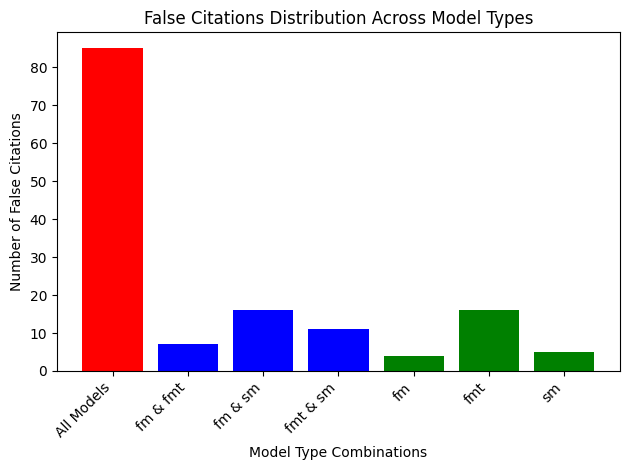

In [33]:
from collections import Counter

import matplotlib.pyplot as plt

# Abbreviations for model names
model_abbreviations = {
    "small_model": "sm",
    "full_model": "fm",
    "full_model_texts": "fmt"
}

# Count the occurrences of specific combinations of two models, individual models, and all models failing
specific_model_counts = Counter()

for models in model_types_per_id.values():
    if len(models) == 3:  # All models failed
        specific_model_counts["All Models"] += 1
    elif len(models) == 2:
        # Sort and abbreviate model names
        abbreviated_models = " & ".join(sorted(model_abbreviations[m] for m in models))
        specific_model_counts[abbreviated_models] += 1
    elif len(models) == 1:
        # Abbreviate single model name
        specific_model_counts[model_abbreviations[models[0]]] += 1

# Prepare data for plotting
# Sort categories: "All Models" first, then combinations of two models, then single models
categories = ["All Models"] + sorted(
    [key for key in specific_model_counts.keys() if " & " in key]
) + sorted(
    [key for key in specific_model_counts.keys() if key not in ["All Models"] and " & " not in key]
)
counts = [specific_model_counts[cat] for cat in categories]

# Assign colors: one color for "All Models", another for combinations of two models, and another for single models
colors = []
for category in categories:
    if category == "All Models":
        colors.append("red")  # Color for "All Models"
    elif " & " in category:
        colors.append("blue")  # Color for combinations of two models
    else:
        colors.append("green")  # Color for single models

# Create the bar plot
plt.bar(categories, counts, color=colors)
plt.xlabel('Model Type Combinations')
plt.ylabel('Number of False Citations')
plt.title('False Citations Distribution Across Model Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
ids_all_models_false = [row_id for row_id, models in model_types_per_id.items() if set(models) == set(model_abbreviations.keys())]
len(ids_all_models_false)

85

In [47]:
model = "full_model_texts"
df = load_df(model)
df_false_classifications = reshape_model_classification(df)
df_false_classifications = df[df.index.isin(ids_all_models_false)]
df_false_classifications.to_pickle(f"../data/dfs/{model}/ReferenceErrorDetection_data_results_false_classifications.pkl")

In [48]:
df_false_classifications.head()

,Source,Citing Article ID,Citing Article DOI,Citing Article Title,Citing Article Retracted,Citing Article Downloaded,Domain,Statement with Citation,Reference Article ID,Reference Article DOI,...,Reference Article PDF Available,Reference Article Retracted,Reference Article Downloaded,Label,Explanation,Top_3_Chunk_IDs,Top_3_Chunk_Texts,Model Classification,Model Classification Label,Model Classification Explanation
3,PubPeer,c003,10.1155/2022/2408685,The Choice of Anesthetic Drugs in Outpatient H...,Yes,Yes,Medicine,Research has shown that remimazolam tosylate e...,r004,10.1186/s12871-018-0543-3,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[4947cbac-d6d7-4f50-9c75-4c101035c923, f9560dc...","[0.001) at 1 year, and 2% (-2 to 6%, non-signi...","{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the effects of...
46,PubPeer,c030,10.2298/gensr2201173y,Evaluation of genetic variability Rindera usin...,Yes,Yes,Biology,"Bees, flies, and honeybees [citation] pollinat...",r044,10.1098/rsbl.2019.0230,...,Yes,No,Yes,unsubstantiate,Different plant species,"[16a3cfad-5ac5-4128-aeb0-0eaa5fccccdb, d648b23...",[Introduction\nInsect pollination is a key eco...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the effectiven...
49,PubPeer,c031,10.2298/gensr2102769m,Gene flow and genetic structure between popula...,Yes,Yes,Biology,Changes in environment often lead to variation...,r047,10.1038/s41392-021-00594-4,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[c01bd902-060b-4cc7-b1ff-916d407cc9d9, 8c1ea04...","[2f ), indicating a reduced mitochondrial resp...","{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the role of RO...
52,PubPeer,c032,10.2298/gensr2103331l,Genetic diversity and gene-pool of Aegilops ta...,Yes,Yes,Biology,"Randomly amplified polymorphic DNA (RAPD), amp...",r050,10.3103/S0095452718040102,...,Yes,No,Yes,unsubstantiate,Different plant species,"[0c13ff08-9734-4b24-9083-8270a5cd9f52, 87474ee...",[Analyses\nFresh leaves were used randomly fro...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article uses ISSR markers for ge...
79,PubPeer,c044,10.1007/s13204-021-02325-1,Solar radiation impact on ferrofluid convectio...,Yes,Yes,Physics,The nanoliquids are a mixture of typical fluid...,r076,10.1016/j.egyr.2021.04.046,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[640ed69f-8b73-4897-bd3b-404ce88bb7f8, cf77e85...",[such as ethylene glycol and water with suitab...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the use of nan...


In [53]:
def print_false_classification_rows(df, model_type):
    output_path = f"../data/false_classifications_{model_type}.txt"
    with open(output_path, 'w') as file:
        for index, row in df.iterrows():
            file.write(f"Row ID: {index}\n")
            file.write("-" * 80 + "\n")
            file.write(f"Target Label: {row['Label']}\n")
            file.write(f"Model Label: {row['Model Classification Label']}\n")
            file.write(f"Reference Article ID: {row['Reference Article ID']}\n")
            file.write(f"Statement: {row['Statement with Citation']}\n")
            file.write("\nTop 3 Chunk Texts:\n")
            for chunk in row['Top_3_Chunk_Texts']:
                file.write(f"- {chunk}\n")
            file.write("\nModel Explanation:\n")
            file.write(row['Model Classification Explanation'] if pd.notnull(row['Model Classification Explanation']) else "No explanation provided")
            file.write("\n" + "=" * 80 + "\n")

In [54]:
print_false_classification_rows(df_false_classifications, model)

## First chunking vs. chunking during index generation 
### ((TokenTextSplitter) vs. (SentenceSplitter))

In [16]:
def remove_json_colons(json_text):
    if json_text and json_text.startswith("```json") and json_text.rstrip().endswith("```"):
        return json_text[7:-3]
    return json_text

In [17]:
def reshape_model_classification(df):
    for index, row in df.iterrows():
        if row['Reference Article Downloaded'] == 'Yes':
            try:
                row['Model Classification'] = remove_json_colons(row['Model Classification'])
                model_classification = json.loads(row['Model Classification'])
                label = model_classification['label'].lower()
                df.at[row.name, 'Model Classification Label'] = label if not label.endswith('d') else label[:-1]
                df.at[row.name, 'Model Classification Explanation'] = model_classification['explanation']
            except json.JSONDecodeError as e:
                print(f"Row {index} Model Classification could not be decoded: {e}")
                print(row['Model Classification'])
                df.at[row.name, 'Model Classification Label'] = None
                df.at[row.name, 'Model Classification Explanation'] = None
        else:
            df.at[row.name, 'Model Classification Label'] = None
            df.at[row.name, 'Model Classification Explanation'] = None
        df.at[row.name, 'Label'] = df.at[row.name, 'Label'].lower()
    return df

In [18]:
import pandas as pd
import json


model_type = "full_model"
embedding = "te3l"

In [19]:
df_chunking_first = pd.read_pickle(f"../data/dfs/{embedding}/{model_type}/ReferenceErrorDetection_data_with_prompt_results.pkl")
df_chunking_first = reshape_model_classification(df_chunking_first)
df_chunking_first.head()

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{



,Source,Citing Article ID,Citing Article DOI,Citing Article Title,Citing Article Retracted,Citing Article Downloaded,Domain,Statement with Citation,Reference Article ID,Reference Article DOI,...,Reference Article PDF Available,Reference Article Retracted,Reference Article Downloaded,Label,Explanation,Top_3_Chunk_IDs,Top_3_Chunk_Texts,Model Classification,Model Classification Label,Model Classification Explanation
0,PubPeer,c001,10.1016/j.est.2021.103553,Heating a residential building using the heat ...,Yes,Yes,Engineering,Others have aimed to reduce irreversibility or...,r001,10.1155/2021/2087027,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[ecb51e4f-6f0b-4abe-8fd1-0b1119d3c57b, 3543f03...",[implementation of fuzzy reasoning spiking neu...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not mention reducin...
1,PubPeer,c001,10.1016/j.est.2021.103553,Heating a residential building using the heat ...,Yes,Yes,Engineering,Some researchers have also studied various hea...,r002,10.1016/j.physa.2018.12.031,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[7609e3bb-6a78-4479-b2fc-23986dba04bc, f25f6b4...",[Sci\n\t\t\n\t\t\t79\n\t\t\t\n\t\t\t2016\n\t\t...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not mention any stu...
2,PubPeer,c002,10.1155/2022/4601350,Oxidative Potential and Nanoantioxidant Activi...,Yes,Yes,Chemistry,The relative content of total flavonoids in th...,r003,10.1088/1742-6596/1937/1/012038,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[19f64acb-c4e7-40b4-bb88-bf12bfd7fda1, 08e6ae8...",[AND RESULTPhotochemical blood performance of ...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not provide any inf...
3,PubPeer,c003,10.1155/2022/2408685,The Choice of Anesthetic Drugs in Outpatient H...,Yes,Yes,Medicine,Research has shown that remimazolam tosylate e...,r004,10.1186/s12871-018-0543-3,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[9dd7fb55-09ad-488c-a9c3-0a25a9cfa560, ebb664a...",[Rep\n\t\t\n\t\t\t37\n\t\t\t2\n\t\t\t\n\t\t\t2...,"{\n ""label"": ""Partially substantiate"",\n ...",partially substantiate,The reference article discusses the effects of...
4,PubPeer,c004,10.1155/2022/4783847,A Fault-Tolerant Structure for Nano-Power Comm...,Yes,Yes,Engineering,if the efficiency of the routing algorithm is ...,r005,10.36410/jcpr.2022.23.3.312,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[fb8d6cc8-5f22-4add-a5c6-4843d8d61043, 199ad27...",[with high centrality are usually the main nod...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article on ceramic materials in ...


In [20]:
df_no_prev_chunking = pd.read_pickle(f"../data/dfs/{embedding}_no_prev_chunking/{model_type}/ReferenceErrorDetection_data_with_prompt_results.pkl")
df_no_prev_chunking = reshape_model_classification(df_no_prev_chunking)
df_no_prev_chunking.head()

Row 22 Model Classification could not be decoded: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)
{



,Source,Citing Article ID,Citing Article DOI,Citing Article Title,Citing Article Retracted,Citing Article Downloaded,Domain,Statement with Citation,Reference Article ID,Reference Article DOI,...,Reference Article PDF Available,Reference Article Retracted,Reference Article Downloaded,Label,Explanation,Top_3_Chunk_IDs,Top_3_Chunk_Texts,Model Classification,Model Classification Label,Model Classification Explanation
0,PubPeer,c001,10.1016/j.est.2021.103553,Heating a residential building using the heat ...,Yes,Yes,Engineering,Others have aimed to reduce irreversibility or...,r001,10.1155/2021/2087027,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[d5149dde-3f61-477d-acd9-0c8f97b154b5, f834613...",[Automatic implementation of fuzzy reasoning s...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not mention anythin...
1,PubPeer,c001,10.1016/j.est.2021.103553,Heating a residential building using the heat ...,Yes,Yes,Engineering,Some researchers have also studied various hea...,r002,10.1016/j.physa.2018.12.031,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[dc4cd1b8-1ae4-4c15-be29-a4eb6e4270ba, 6210cc4...",[Heat transfer improvement of water/single-wal...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not mention any stu...
2,PubPeer,c002,10.1155/2022/4601350,Oxidative Potential and Nanoantioxidant Activi...,Yes,Yes,Chemistry,The relative content of total flavonoids in th...,r003,10.1088/1742-6596/1937/1/012038,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[2eeaa48b-a7ec-4674-87ac-511b439139c8, 0d45e20...",[The correspondence curve for our photochemica...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not provide any inf...
3,PubPeer,c003,10.1155/2022/2408685,The Choice of Anesthetic Drugs in Outpatient H...,Yes,Yes,Medicine,Research has shown that remimazolam tosylate e...,r004,10.1186/s12871-018-0543-3,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[c6131293-c506-4347-8441-06e480444093, 821ac75...",[Determination of the median effective concent...,"{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article does not provide any inf...
4,PubPeer,c004,10.1155/2022/4783847,A Fault-Tolerant Structure for Nano-Power Comm...,Yes,Yes,Engineering,if the efficiency of the routing algorithm is ...,r005,10.36410/jcpr.2022.23.3.312,...,Yes,No,Yes,unsubstantiate,Irrelevant,"[65b14485-4faa-441e-9aac-9967bad1f603, 8b03de6...","[In the table, China's intermediary centrality...","{\n ""label"": ""Unsubstantiate"",\n ""explan...",unsubstantiate,The reference article on ceramic materials in ...


In [27]:
def detect_rows_no_prev_chunking_better(df_chunking_first, df_no_prev_chunking):
    row_infos = {}

    for index, row in df_chunking_first.iterrows():
        if row['Model Classification Label'] != row['Label'] and df_no_prev_chunking.at[index, 'Model Classification Label'] == df_no_prev_chunking.at[index, 'Label']:
            # Check if the citating article id and reference article id are the same in both dataframes
            assert row['Citing Article ID'] == df_no_prev_chunking.at[index, 'Citing Article ID'], "Citing Article IDs do not match"
            assert row['Reference Article ID'] == df_no_prev_chunking.at[index, 'Reference Article ID'], "Reference Article IDs do not match"

            row_infos[index] = {
                'index': index,
                'Statement with Citation': row['Statement with Citation'],
                'Label': row['Label'],
                'df_chunking_first': {
                    'Model Classification Label': row['Model Classification Label'],
                    'Top_3_Chunk_Texts': row['Top_3_Chunk_Texts'],
                    'Model Classification Explanation': row['Model Classification Explanation']
                },
                'df_no_prev_chunking': {
                    'Model Classification Label': df_no_prev_chunking.at[index, 'Model Classification Label'],
                    'Top_3_Chunk_Texts': df_no_prev_chunking.at[index, 'Top_3_Chunk_Texts'],
                    'Model Classification Explanation': df_no_prev_chunking.at[index, 'Model Classification Explanation']
                }
            }

    return row_infos

In [28]:
row_infos = detect_rows_no_prev_chunking_better(df_chunking_first, df_no_prev_chunking)

In [29]:
len(row_infos)

19

In [30]:
row_infos

{3: {'index': 3,
  'Statement with Citation': 'Research has shown that remimazolam tosylate exhibited a time-dependent half-life independent of infusion time compared with dexmedetomidine and propofol and had a shorter awakening time than propofol in gastroscopic practices [citation 22].',
  'Label': 'unsubstantiate',
  'df_chunking_first': {'Model Classification Label': 'partially substantiate',
   'Top_3_Chunk_Texts': ['Rep\n\t\t\n\t\t\t37\n\t\t\t2\n\t\t\t\n\t\t\t2017\n\t\t\n\t\n\n\n\n\t\n\t\tProstate cancer cell malignancy via modulation of HIF-1alpha pathway with isoflurane and propofol alone and in combination\n\t\t\n\t\t\tHHuang\n\t\t\n\t\t\n\t\t\tLLBenzonana\n\t\t\n\t\t\n\t\t\tHZhao\n\t\t\n\t\t\n\t\t\tHRWatts\n\t\t\n\t\t\n\t\t\tNJPerry\n\t\t\n\t\t\n\t\t\tCBevan\n\t\t\n\t\t\n\t\t\tRBrown\n\t\t\n\t\t\n\t\t\tDMa\n\t\t\n\t\n\t\n\t\tBr J Cancer\n\t\t\n\t\t\t111\n\t\t\t7\n\t\t\t\n\t\t\t2014\n\t\t\n\t\n\n\n\n\t\n\t\tPropofol EC50 for inducing loss of consciousness is lower in the lutea

In [70]:
def display_top_chunk_texts(top_chunk_texts, file):
    for index, text in enumerate(top_chunk_texts):
        file.write(f"Excerpt {index+1}:\n")
        # Remove leading and trailing spaces and split by whitespace to remove extra spaces
        cleaned_text = " ".join(text.split())
        # Write the cleaned text to the file
        file.write(cleaned_text + "\n\n")


In [72]:
with open("../data/first_chunking_vs_no_prev_chunking_results.txt", "w", encoding="utf-8") as file:
    for index, row_info in row_infos.items():
        file.write(f"Row ID: {index}\n")
        file.write(f"Label: {row_info['Label']}\n\n")
        file.write(f"Statement with Citation:\n{row_info['Statement with Citation']}\n")
        file.write("_ _ _ _ _ _ _ _ _ _\n")
        file.write("Results from df_chunking_first:\n")
        file.write(f"Model Classification Label: {row_info['df_chunking_first']['Model Classification Label']}\n")
        file.write(f"Model Classification Explanation:\n{row_info['df_chunking_first']['Model Classification Explanation']}\n\n")
        file.write("Top 3 Chunk Texts:\n")
        display_top_chunk_texts(row_info['df_chunking_first']['Top_3_Chunk_Texts'], file)
        file.write("_ _ _ _ _ _ _ _ _ _\n")
        file.write("Results from df_no_prev_chunking:\n")
        file.write(f"Model Classification Label: {row_info['df_no_prev_chunking']['Model Classification Label']}\n")
        file.write(f"Model Classification Explanation:\n{row_info['df_no_prev_chunking']['Model Classification Explanation']}\n\n")
        file.write("Top 3 Chunk Texts:\n")
        display_top_chunk_texts(row_info['df_no_prev_chunking']['Top_3_Chunk_Texts'], file)
        file.write("\n====================================================================\n\n")


In [74]:
from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

#### Difference in number of tokens (different library, just for estimation)

In [98]:
number_tokens_total = {}

for index, row_info in row_infos.items():
    print(f"Row ID: {index}")
    print(f"Label: {row_info['Label']}")

    chunking_first_texts = row_info['df_chunking_first']['Top_3_Chunk_Texts']
    print("Chunking First:")
    chunking_first_total = 0
    for index2, text in enumerate(chunking_first_texts):
        token_count = count_tokens(text)
        chunking_first_total += token_count
        print(f"Excerpt {index2+1}:  {token_count}")
    print(f"Total:      {chunking_first_total}")
    number_tokens_total[index] = {}
    number_tokens_total[index]['chunking_first'] = chunking_first_total
    print("")

    no_prev_chunking_texts = row_info['df_no_prev_chunking']['Top_3_Chunk_Texts']
    print("No Prev Chunking:")
    no_prev_chunking_total = 0
    for index3, text in enumerate(no_prev_chunking_texts):
        token_count = count_tokens(text)
        no_prev_chunking_total += token_count
        print(f"Excerpt {index3+1}:  {token_count}")
    print(f"Total:      {no_prev_chunking_total}")
    number_tokens_total[index]['no_prev_chunking'] = no_prev_chunking_total
    print("")

    number_tokens_total[index]['no_prev_less'] = chunking_first_total - no_prev_chunking_total
    print(f"'No Prev Chunking' has {chunking_first_total - no_prev_chunking_total} less tokens than 'Chunking First'")
    print("\n====================================================================")

Row ID: 3
Label: unsubstantiate
Chunking First:
Excerpt 1:  78
Excerpt 2:  82
Excerpt 3:  216
Total:      376

No Prev Chunking:
Excerpt 1:  75
Excerpt 2:  142
Excerpt 3:  74
Total:      291

'No Prev Chunking' has 85 less tokens than 'Chunking First'

Row ID: 6
Label: unsubstantiate
Chunking First:
Excerpt 1:  186
Excerpt 2:  88
Excerpt 3:  89
Total:      363

No Prev Chunking:
Excerpt 1:  94
Excerpt 2:  136
Excerpt 3:  70
Total:      300

'No Prev Chunking' has 63 less tokens than 'Chunking First'

Row ID: 83
Label: unsubstantiate
Chunking First:
Excerpt 1:  69
Excerpt 2:  199
Excerpt 3:  185
Total:      453

No Prev Chunking:
Excerpt 1:  49
Excerpt 2:  55
Excerpt 3:  41
Total:      145

'No Prev Chunking' has 308 less tokens than 'Chunking First'

Row ID: 94
Label: partially substantiate
Chunking First:
Excerpt 1:  216
Excerpt 2:  201
Excerpt 3:  195
Total:      612

No Prev Chunking:
Excerpt 1:  196
Excerpt 2:  163
Excerpt 3:  171
Total:      530

'No Prev Chunking' has 82 less tok

In [99]:
number_tokens_total

{3: {'chunking_first': 376, 'no_prev_chunking': 291, 'no_prev_less': 85},
 6: {'chunking_first': 363, 'no_prev_chunking': 300, 'no_prev_less': 63},
 83: {'chunking_first': 453, 'no_prev_chunking': 145, 'no_prev_less': 308},
 94: {'chunking_first': 612, 'no_prev_chunking': 530, 'no_prev_less': 82},
 117: {'chunking_first': 490, 'no_prev_chunking': 446, 'no_prev_less': 44},
 124: {'chunking_first': 689, 'no_prev_chunking': 531, 'no_prev_less': 158},
 144: {'chunking_first': 589, 'no_prev_chunking': 586, 'no_prev_less': 3},
 156: {'chunking_first': 332, 'no_prev_chunking': 284, 'no_prev_less': 48},
 165: {'chunking_first': 620, 'no_prev_chunking': 496, 'no_prev_less': 124},
 188: {'chunking_first': 561, 'no_prev_chunking': 509, 'no_prev_less': 52},
 190: {'chunking_first': 489, 'no_prev_chunking': 342, 'no_prev_less': 147},
 191: {'chunking_first': 477, 'no_prev_chunking': 557, 'no_prev_less': -80},
 195: {'chunking_first': 525, 'no_prev_chunking': 281, 'no_prev_less': 244},
 207: {'chunk

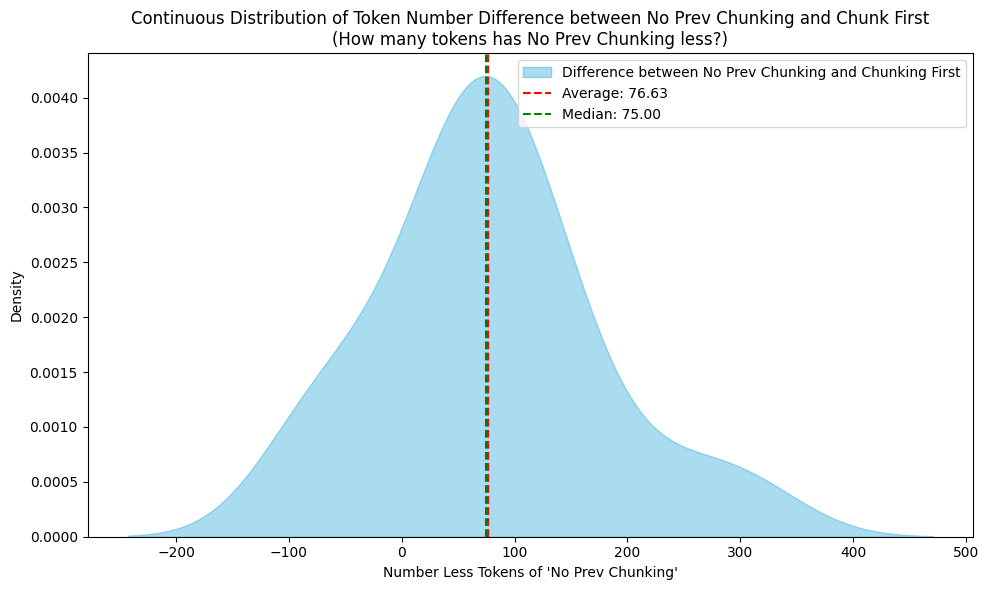

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'no_prev_less' values from number_tokens_total
no_prev_less_values = [info['no_prev_less'] for info in number_tokens_total.values()]

# Calculate the average and median
average = np.mean(no_prev_less_values)
median = np.median(no_prev_less_values)

# Create the KDE plot for a continuous distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(no_prev_less_values, color='skyblue', fill=True, alpha=0.7, label='Difference between No Prev Chunking and Chunking First')

# Add vertical lines for average and median
plt.axvline(average, color='red', linestyle='dashed', linewidth=1.5, label=f'Average: {average:.2f}')
plt.axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median:.2f}')

# Add labels and title
plt.xlabel("Number Less Tokens of 'No Prev Chunking'")
plt.ylabel('Density')
plt.title('Continuous Distribution of Token Number Difference between No Prev Chunking and Chunk First\n(How many tokens has No Prev Chunking less?)')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Per 3 excerpts, chunking with SentenceSplitter during the index generation leads to 75 tokens less (25 per excerpt) on average which leads to better results than with TokenTextSplitter (only on the false classifications on TokenTextSplitter, which were correct with SentenceSplitter).

--> Check total distribution next?